# <font color='green'> LSTM for MNIST using Pytorch</font>

## 0. Ready for LSTM


- MNIST : 28 x 28 x 1의 image
(28차원의 dimension(세로)을 갖는 28차원의 sequence(가로))
- MNIST label : 0~9까지의 숫자


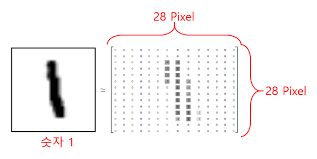

- 즉, 이미지를 Time Sequence로 바라보고 LSTM 적용

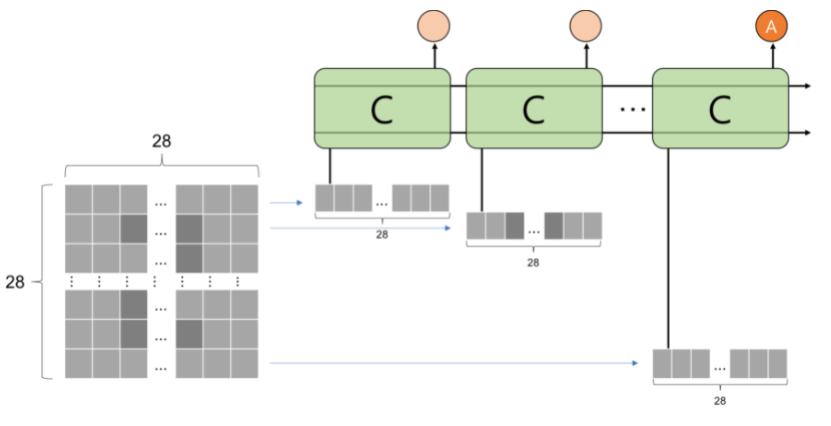

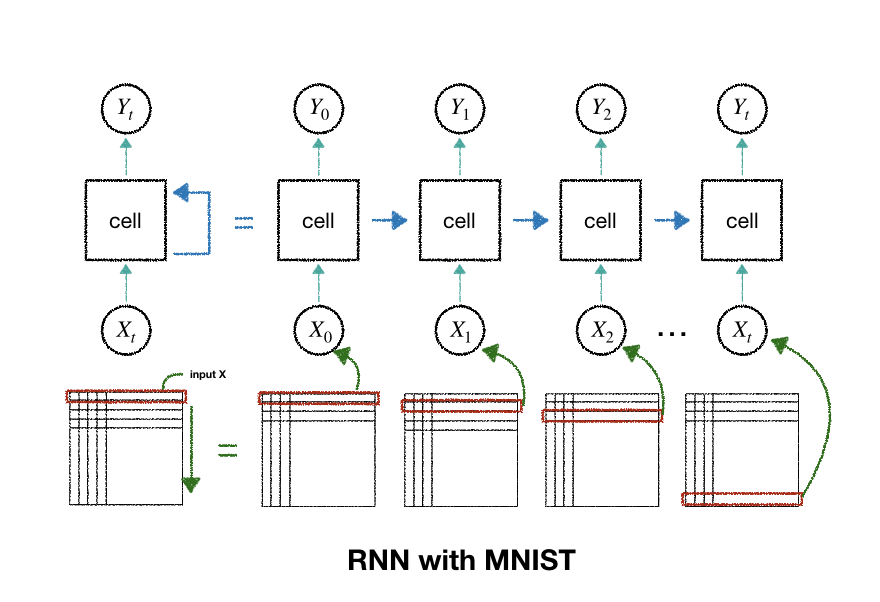

- 이 때, 위의 time step 별 output Yt는 각 time step에서 반환하기로 한 ht에 해당

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Device Settings
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print('device : ', device)

device :  cuda


In [2]:
# Hyperparameter Setting

sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.01

## 1. Load Dataset

torchvision이 제공하는 dataset은 torch.utils.data.Dataset을 상속하기 때문에 torch.utils.data.DataLoader로 전달될 수 있다.

In [3]:
# MNIST dataset

train_dataset = torchvision.datasets.MNIST(root = '../../data', 
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)
test_dataset = torchvision.datasets.MNIST(root = '../../data', 
                                           train=False,
                                           transform=transforms.ToTensor())

# Data Loader

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size = batch_size,
                                           shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw



## 2. RNN class define

- RNN은 굉장히 넓은 개념이기 때문에 클래스 이름은 RNN
- RNN 내부의 (hidden)cell이 바닐라 LSTM인지, LSTM인지, GRU인지에 따라 구체적인 기능이 달라짐.
- 최종적으로 MNIST의 10개의 class를 예측해야 하기 때문에 Fully Connected Layer를 마지막에 달아주어야 함
- forward에서는, 보통 딥러닝에서는 BATCH 단위로 학습을 진행하기 때문에, INPUT DATA의 첫번째 차원을 BATCH SIZE로 맞춰주기 위해 LSTM layer에서 batch_first=True 속성을 적용해줌. 
- 위의 정의대로 하면 28 time step을 갖기 때문에, 최종적인 output에서도 마지막 time step의 output만 가져오면 된다(out[:, -1, :])

In [4]:
# RNN class 정의 (many-to-one)

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__() # 상속한 nn.Module에서 RNN에 해당하는 init 실행
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x): 
        # input x : (BATCH, LENGTH, INPUT_SIZE) 입니다 (다양한 length를 다룰 수 있습니다.).
        # 최초의 hidden state와 cell state를 초기화시켜주어야 합니다.
        # 배치 사이즈는 가변적이므로 클래스 내에선 표현하지 않습니다.
        # 만약 Bi-directional LSTM이라면 아래의 hidden and cell states의 첫번째 차원은 2*self.num_layers 입니다. 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # (BATCH SIZE, SEQ_LENGTH, HIDDEN_SIZE)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # hidden state와 동일

        # LSTM 순전파
        out, _ = self.lstm(x, (h0, c0)) # output : (BATCH_SIZE, SEQ_LENGTH, HIDDEN_SIZE) tensors. (hn, cn)은 필요 없으므로 받지 않고 _로 처리합니다. 

        # 마지막 time step(sequence length)의 hidden state를 사용해 Class들의 logit을 반환합니다(hidden_size -> num_classes). 
        out = self.fc(out[:, -1, :])
        return out

## 3. Train

In [5]:
# 모델 할당 후 학습
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device) # 

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss() # 분류
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 학습

total_step = len(train_loader) # 배치 개수
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
       images = images.reshape(-1, sequence_length, input_size).to(device) # (BATCH(100), 1, 28, 28) -> (BATCH(100), 28, 28)
       labels = labels.to(device) # Size : (100)

       # 순전파
       outputs = model(images)
       loss = criterion(outputs, labels)

       # 역전파 & 최적화
       optimizer.zero_grad()
       loss.backward()
       optimizer.step()

       if (i+1) % 100 == 0: 
         print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
             epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/2], Step [100/600], Loss: 0.5313
Epoch [1/2], Step [200/600], Loss: 0.1384
Epoch [1/2], Step [300/600], Loss: 0.1349
Epoch [1/2], Step [400/600], Loss: 0.1687
Epoch [1/2], Step [500/600], Loss: 0.1901
Epoch [1/2], Step [600/600], Loss: 0.2906
Epoch [2/2], Step [100/600], Loss: 0.2300
Epoch [2/2], Step [200/600], Loss: 0.0614
Epoch [2/2], Step [300/600], Loss: 0.0806
Epoch [2/2], Step [400/600], Loss: 0.0863
Epoch [2/2], Step [500/600], Loss: 0.0455
Epoch [2/2], Step [600/600], Loss: 0.0616


## 4. Evaluation

In [6]:
model.eval() # Dropout, Batchnorm 등 실행 x
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1) # logit(확률)이 가장 큰 class index 반환
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 


Test Accuracy of the model on the 10000 test images: 97.64 %
